In [ ]:
!pip install -U  keras-nlp

  Using cached keras_nlp-0.6.2-py3-none-any.whl (590 kB)


In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
import keras_nlp

Using TensorFlow backend


In [ ]:
!nvidia-smi --query-gpu=memory.total --format=csv,noheader
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.set_logical_device_configuration(
    physical_devices[0],
    [
        tf.config.LogicalDeviceConfiguration(memory_limit=15360 // 2),
        tf.config.LogicalDeviceConfiguration(memory_limit=15360 // 2),
    ],
)

logical_devices = tf.config.list_logical_devices("GPU")
logical_devices


PRETRAINING_BATCH_SIZE = 128

15360 MiB


In [ ]:

print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
strategy = tf.distribute.MirroredStrategy()
print(f"Number of devices: {strategy.num_replicas_in_sync}")

Number of devices: 2


In [ ]:
!pip install -q tensorflow_text

In [ ]:
!wget -q https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz
!tar xf tweet_images.tar.gz

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow import keras

In [ ]:
label_map = {
    "Contradictory": 0,
    "Implies": 1,
    "NoEntailment": 2
}


In [ ]:

df = pd.read_csv("https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv")
df.sample(10)

,id_1,text_1,image_1,id_2,text_2,image_2,label
799,1371212894843633671,Nothing to say I’m just trying to get off Twit...,http://pbs.twimg.com/media/EweG22HXMAAg9fN.jpg,1372308222963548163,We’re going to a quest #RenewMML https://t.co/...,http://pbs.twimg.com/media/EwtrDbwXMAMOIba.jpg,NoEntailment
401,1372527534315859970,Our Sleep Blend Tincture encourages deep sleep...,http://pbs.twimg.com/media/EwwyhNuXAAIM9Hk.jpg,1372901946860859395,Our Sleep Blend Tincture encourages deep #slee...,http://pbs.twimg.com/media/Ew2HC4LXMAEXzU7.jpg,NoEntailment
1012,1335327038497058818,I missed his live 😩\n#ParthSamthaan \n\nKal ka...,http://pbs.twimg.com/media/EobyaAgU8AAEmf8.jpg,1355508904017473541,The cuteness &amp; goofiness still remains the...,http://pbs.twimg.com/media/Es-8AYbXYAAwt33.jpg,NoEntailment
1284,1380047278824517633,Air Jordan 5 Low “Black/Metallic Gold” Releasi...,http://pbs.twimg.com/media/EybprmtUYAEyXyl.jpg,1381370063190552576,【Air Jordan 5 Low】\nColorway: Black / Metallic...,http://pbs.twimg.com/media/Eyucv_BVEAEpBQ_.jpg,NoEntailment
630,1335804831269675011,Taxi Hold Lot Status on 12-6-2020 @ 11:30 p.m....,http://pbs.twimg.com/media/Eom6jYCXUAE13VS.jpg,1336076623653855237,Taxi Hold Lot Status\non 12/7/2020 @ 5:30pm \n...,http://pbs.twimg.com/media/EoqyYrFXIAMFv46.jpg,NoEntailment
946,1359873776167641088,$BHTG 37.62% down since our short signal. Trie...,http://pbs.twimg.com/media/Et89_jgXAAUA9x6.png,1359874716425744386,$BPTH 47.62% down since our short signal. Trie...,http://pbs.twimg.com/media/Et8-2RiXEAA7vWf.png,NoEntailment
1162,1358652983119077376,Nailed by V\nBook Here⬇️\nhttps://t.co/3OkQgFk...,http://pbs.twimg.com/media/Etrnr-2XUAAabs3.jpg,1358798567545176065,Nailed by V \nBook Here ⬇️\nhttps://t.co/3OkQg...,http://pbs.twimg.com/media/EttsF29WYAAXHwk.jpg,NoEntailment
285,1374398033396432897,May KC #Wheat Chart\n➡️➡️Wheat has busted out ...,http://pbs.twimg.com/media/ExLGwipVkAAj0XT.jpg,1380200011888164864,May KC #Wheat Chart\n👉Technicals are bottoming...,http://pbs.twimg.com/media/EydvxoCXIAMPK5J.jpg,NoEntailment
166,1348633278681669632,The 2021 #BHCCommunityForum is going virtual! ...,http://pbs.twimg.com/media/ErdO0gwXYAIyYQy.png,1364613686816628738,Join over 300 business and health care leaders...,http://pbs.twimg.com/media/EvATktyXcAkJK6j.jpg,NoEntailment
848,1355716455807987713,What a twist.\n\nYou can find me at Deviantart...,http://pbs.twimg.com/media/EtB4zPuXMAI7RdF.jpg,1358256710046150658,BIGGER BIGGER.\n\nYou can find me at Deviantar...,http://pbs.twimg.com/media/Etl_KuNXcAEbvr4.jpg,NoEntailment


In [ ]:
images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".") [-1]
    extentsion_two = current_row["image_2"].split(".") [-1]

    image_one_path = os.path.join("tweet_images", str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join("tweet_images", str(id_2) + f".{extentsion_two}")

    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)


df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths



df["label_idx"] = df["label"].apply(lambda x: label_map[x])

In [ ]:
df["label"].value_counts()

NoEntailment     1182
Implies           109
Contradictory     109
Name: label, dtype: int64

In [ ]:

train_df, test_df = train_test_split(df, test_size=0.1,
                                     stratify=df["label"].values, random_state=42)

train_df, val_df = train_test_split(train_df, test_size=0.05,
                                     stratify=train_df["label"].values, random_state=42)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 1197
Total validation examples: 63
Total test examples: 140


In [ ]:
bert_model_path = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

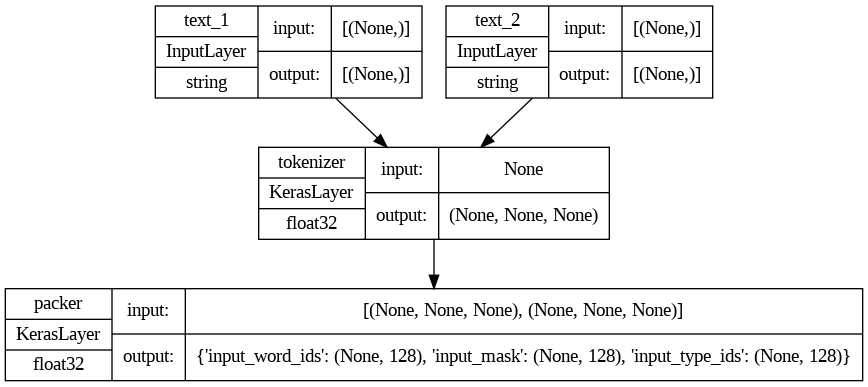

In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=128):


  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]


  bert_preprocess = hub.load(bert_preprocess_path)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]


  truncated_segments = segments


  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          name='packer')
  model_inputs = packer(truncated_segments)
  return keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocess_model(['text_1', 'text_2'])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

In [ ]:

idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["text_1"], row["text_2"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

Text 1: Sat 13:00: Sunny; Temp -0.9 C; Humidity 60%; Press 102.3 kPa. https://t.co/vkLkS5yR4P
Text 2: Wed 10:00: Sunny; Temp 10.5 C; Humidity 43%; Press 101.5 kPa. https://t.co/fCLy4QTqrv


In [ ]:
test_text = [np.array([sample_text_1]),
    np.array([sample_text_2])]
text_preprocessed = bert_preprocess_model(test_text)

print('Keys           : ', list(text_preprocessed.keys()))
print('Shape Word Ids : ', text_preprocessed['input_word_ids'].shape)
print('Word Ids       : ', text_preprocessed['input_word_ids'][0, :16])
print('Shape Mask     : ', text_preprocessed['input_mask'].shape)
print('Input Mask     : ', text_preprocessed['input_mask'][0, :16])
print('Shape Type Ids : ', text_preprocessed['input_type_ids'].shape)
print('Type Ids       : ', text_preprocessed['input_type_ids'][0, :16])

Keys           :  ['input_word_ids', 'input_mask', 'input_type_ids']
Shape Word Ids :  (1, 128)
Word Ids       :  tf.Tensor(
[  101  2938  2410  1024  4002  1024 11559  1025  8915  8737  1011  1014
  1012  1023  1039  1025], shape=(16,), dtype=int32)
Shape Mask     :  (1, 128)
Input Mask     :  tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(16,), dtype=int32)
Shape Type Ids :  (1, 128)
Type Ids       :  tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(16,), dtype=int32)


In [ ]:
def dataframe_to_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    return ds

In [ ]:
resize = (128, 128)
bert_input_features = ['input_word_ids', 'input_type_ids', 'input_mask']

def read_resize(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image

def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    output = bert_preprocess_model([text_1, text_2])
    output = {feature: tf.squeeze(output[feature])
        for feature in bert_input_features}
    return output

def preprocess(sample):
    image_1 = read_resize(sample["image_1_path"])
    image_2 = read_resize(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}


In [ ]:
batch_size = 32
auto = tf.data.AUTOTUNE

def prepare_dataset(df, training=True):
    ds = dataframe_to_dataset(df)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess(x), y))
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)



def separate_labels(ds):
    labels = []
    for _, label in ds.unbatch():
        labels.append(label)
    labels = np.array(labels)
    return labels

train_labels = separate_labels(train_ds)
test_labels = separate_labels(test_ds)


train_labels.shape, test_labels.shape

((1197,), (140,))

In [ ]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

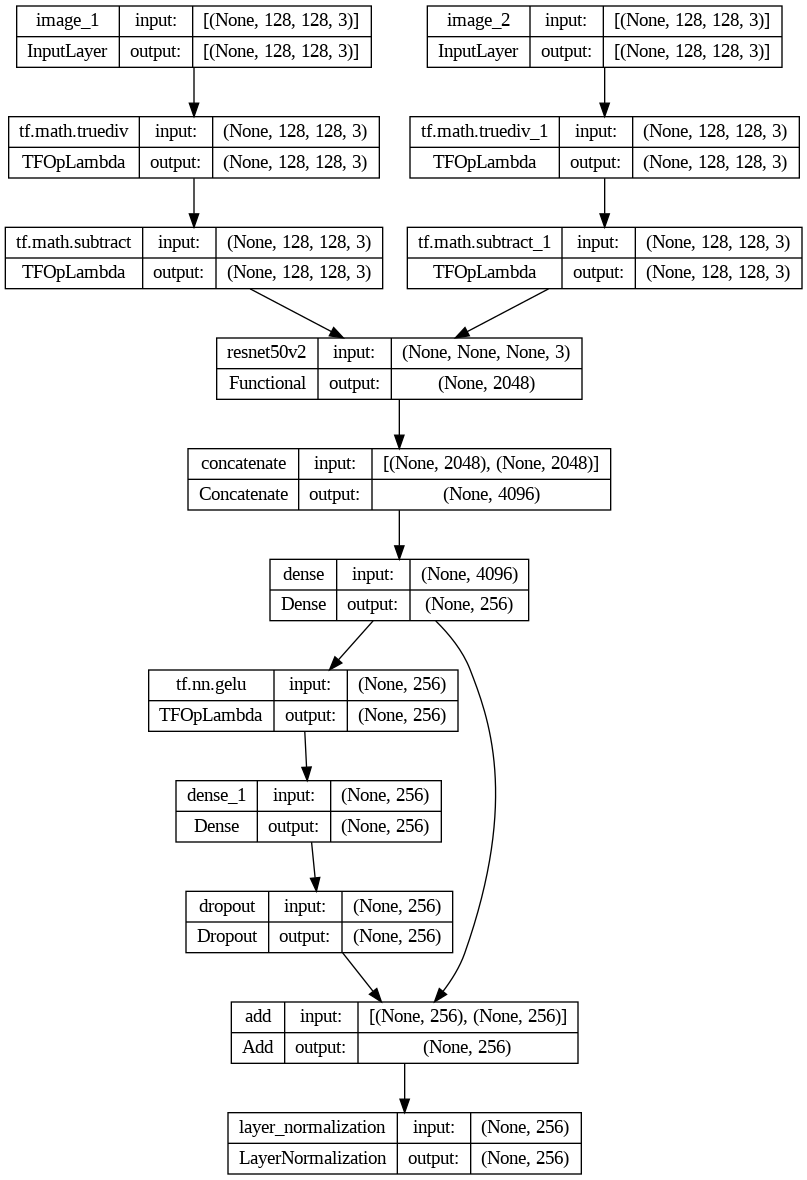

In [ ]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):

    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )

    for layer in resnet_v2.layers:
        layer.trainable = trainable


    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")


    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)


    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])


    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )

    return keras.Model([image_1, image_2], outputs, name="vision_encoder")


vision_encoder = create_vision_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
keras.utils.plot_model(vision_encoder, show_shapes=True)

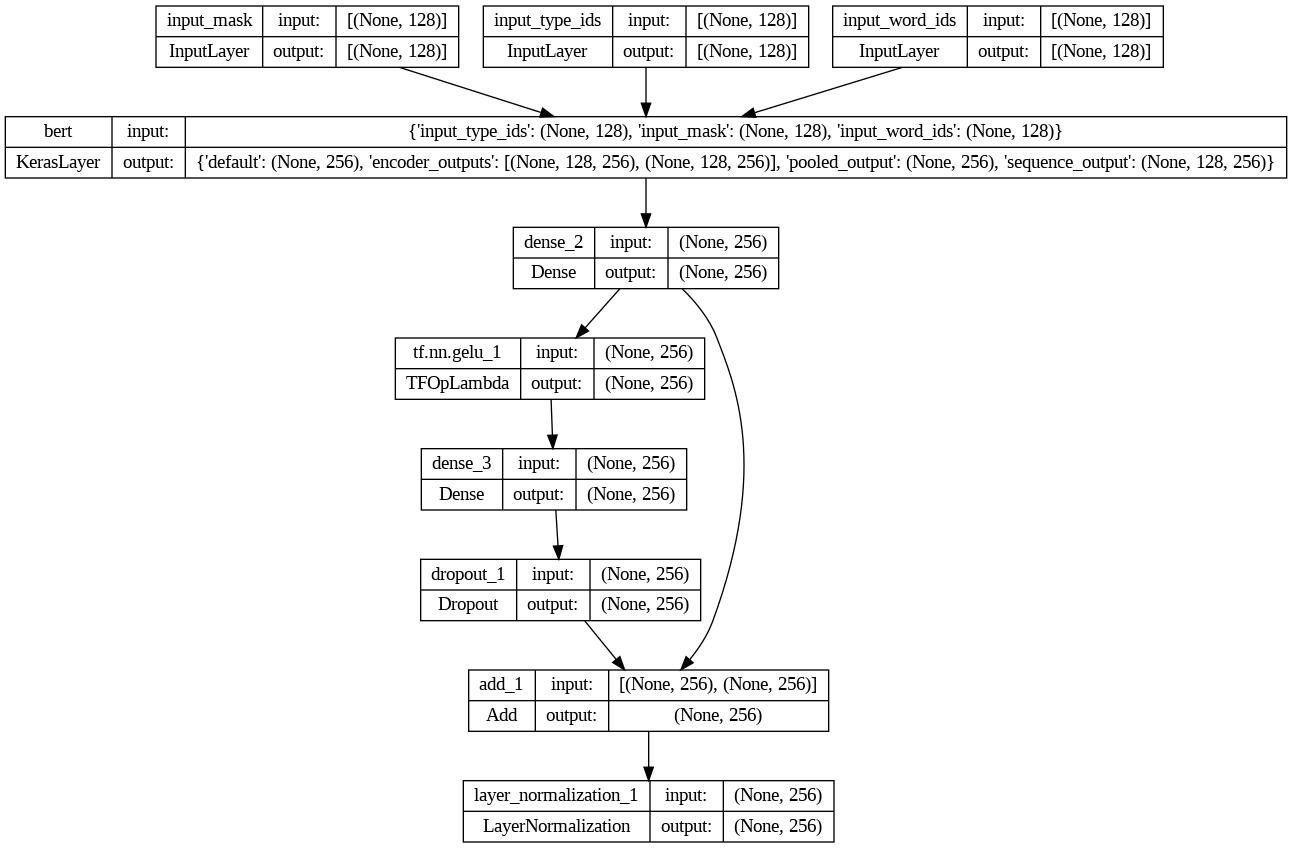

In [ ]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):

    bert = hub.KerasLayer(
        bert_model_path,
        name="bert",
    )

    bert.trainable = trainable


    bert_input_features = ['input_type_ids', 'input_mask', 'input_word_ids']
    inputs = {
        feature: keras.Input(shape=(128, ), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    embeddings = bert(inputs)["pooled_output"]


    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )

    return keras.Model(inputs, outputs, name="text_encoder")


text_encoder = create_text_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
keras.utils.plot_model(text_encoder, show_shapes=True)

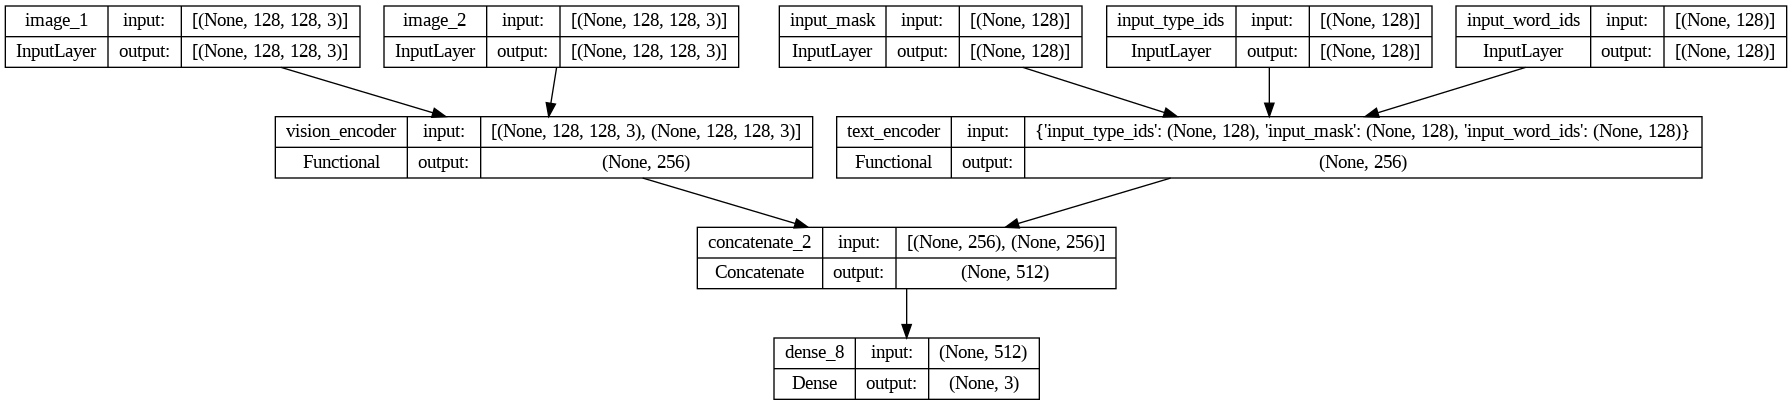

In [ ]:
def create_multimodal_model(num_projection_layers=1, projection_dims=256, dropout_rate=0.1,
                     vision_trainable=False, text_trainable=False):

    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")


    bert_input_features = ['input_type_ids', 'input_mask', 'input_word_ids']
    text_inputs = {
        feature: keras.Input(shape=(128, ), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }


    vision_encoder = create_vision_encoder(num_projection_layers, projection_dims, dropout_rate, vision_trainable)
    text_encoder = create_text_encoder(num_projection_layers, projection_dims, dropout_rate, text_trainable)


    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)


    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, image_2, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

In [ ]:
with strategy.scope():
  multimodal_model = create_multimodal_model()
  multimodal_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")


  history = multimodal_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=10
  )

Epoch 1/10
38/38 [==============================] - 78s 785ms/step - loss: 0.9720 - accuracy: 0.8246 - val_loss: 0.5922 - val_accuracy: 0.8571
Epoch 2/10
38/38 [==============================] - 27s 721ms/step - loss: 0.4325 - accuracy: 0.8739 - val_loss: 0.6005 - val_accuracy: 0.8571
Epoch 3/10
38/38 [==============================] - 24s 633ms/step - loss: 0.3684 - accuracy: 0.8814 - val_loss: 0.5865 - val_accuracy: 0.8571
Epoch 4/10
38/38 [==============================] - 34s 915ms/step - loss: 0.2902 - accuracy: 0.9073 - val_loss: 0.6344 - val_accuracy: 0.8571
Epoch 5/10
38/38 [==============================] - 27s 710ms/step - loss: 0.2010 - accuracy: 0.9332 - val_loss: 0.8273 - val_accuracy: 0.8413
Epoch 6/10
38/38 [==============================] - 26s 691ms/step - loss: 0.1409 - accuracy: 0.9474 - val_loss: 0.7569 - val_accuracy: 0.8571
Epoch 7/10
38/38 [==============================] - 29s 760ms/step - loss: 0.0951 - accuracy: 0.9699 - val_loss: 1.2233 - val_accuracy: 0.8571

In [ ]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

5/5 [==============================] - 8s 403ms/step - loss: 1.0429 - accuracy: 0.8357
Accuracy on the test set: 83.57%.
